I provide two ways of modeling seasonal effect. For effects that take less values (e.g. weekly effects), we can assign a state value to each day. For effects that have a longer cycle (e.g. quarterly effects), we may model them using trigonmetric cycles.


In [1]:
"""
Cyclical model
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization
A cyclical model can be written as:

$\begin{pmatrix}\phi_t \\\phi_t^{*}\end{pmatrix} = \rho 
\begin{pmatrix}cos\lambda & sin\lambda \\-sin\lambda & cos\lambda 
\end{pmatrix}\begin{pmatrix}\phi_{t-1} \\ \phi_{t-1}^{*}\end{pmatrix} 
+ \begin{pmatrix}\omega_{t-1} \\ \omega_{t-1}^{*}\end{pmatrix}$

$y_t = \phi_t + \varepsilon_t$

$\lambda$ determines the cycle frequency, and $\rho$ is the dampening factor. If $\rho=1$, the process is non-stationary. 

In [2]:
def my_f(theta):
    # Generate F
    lambda_ = np.pi / (1 + np.exp(theta[0]))  
    rho = 1 / (1 + np.exp(theta[3]))
    sigQ = np.exp(theta[1])
    sigR = np.exp(theta[2])
    F = rho * np.array([[np.cos(lambda_), np.sin(lambda_)], [-np.sin(lambda_), np.cos(lambda_)]])
    # Generate Q
    Q = np.array([[sigQ, 0], [0, sigQ]]) 
    R = np.array([[sigR]])
    # Generate H
    H = np.array([[1, 0]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([2, -0.1, 0.2, -3])  
T = 365
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  
missing_range = [0.3, 0.5]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ks_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ks_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ks_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ks_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

theta is [0.09790015 0.47601372 0.27163386 0.21733493]. Function value is: -699.3885768844433.
theta is [0.10340704 0.47884713 0.28691327 0.19967646]. Function value is: -696.4913276516972.
theta is [0.09407593 0.49797269 0.29837282 0.20816611]. Function value is: -693.0203932011665.
theta is [0.09407593 0.49797269 0.29837282 0.20816611]. Function value is: -693.0203932011665.
theta is [0.09581595 0.53932284 0.29768313 0.178325  ]. Function value is: -687.5029689545042.
theta is [0.09914781 0.56413735 0.33080177 0.15993431]. Function value is: -679.7464048534496.
theta is [0.09914781 0.56413735 0.33080177 0.15993431]. Function value is: -679.7464048534496.
theta is [0.08517086 0.62118473 0.36853772 0.12918455]. Function value is: -670.3049844228942.
theta is [0.09027067 0.7284692  0.3893293  0.06689211]. Function value is: -656.117090768897.
theta is [0.09027067 0.7284692  0.3893293  0.06689211]. Function value is: -656.117090768897.
theta is [ 0.08902099  0.8148395   0.48515608 -0.020

theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.78951879  1.15359881 -0.84908459 -1.04830073]. Function value is: -416.1242444216481.
theta is [ 2.72747904  1.1116175  -0.60360166 -1.14253902]. Function value is: -415.55100200260404.
theta is [ 2.72747904  1.1116175  -0.60360166 -1.14253902]. Function value is: -415.55100200260404.
theta is [ 2.72747904  1.1116175  -0.60360166 -1.14253902]. Function value is: -415.55100200260404.
theta i

theta is [ 2.03607292  0.96831771 -1.01034984 -1.53268595]. Function value is: -406.54086655982854.
theta is [ 2.05388185  0.9507022  -1.02961056 -1.67184459]. Function value is: -406.35439041131286.
theta is [ 2.09235698  0.88175949 -0.64738364 -1.50296121]. Function value is: -405.081919458047.
theta is [ 2.09235698  0.88175949 -0.64738364 -1.50296121]. Function value is: -405.081919458047.
theta is [ 2.09235698  0.88175949 -0.64738364 -1.50296121]. Function value is: -405.081919458047.
theta is [ 2.05114273  0.77484173 -0.31500194 -1.74083864]. Function value is: -403.3122607836002.
theta is [ 2.05114273  0.77484173 -0.31500194 -1.74083864]. Function value is: -403.3122607836002.
theta is [ 2.02747212  0.65261396 -0.10451242 -1.68907329]. Function value is: -402.62866797567057.
theta is [ 2.02747212  0.65261396 -0.10451242 -1.68907329]. Function value is: -402.62866797567057.
theta is [ 2.02747212  0.65261396 -0.10451242 -1.68907329]. Function value is: -402.62866797567057.
theta is

theta is [ 2.02459193  0.03762743  0.14413943 -2.42471925]. Function value is: -396.9370988574821.
theta is [ 2.02461207  0.03763353  0.14412213 -2.42469144]. Function value is: -396.9370988453617.
theta is [ 2.02461207  0.03763353  0.14412213 -2.42469144]. Function value is: -396.9370988453617.
theta is [ 2.0246034   0.03760022  0.14416468 -2.42475371]. Function value is: -396.9370988351109.
theta is [ 2.0246034   0.03760022  0.14416468 -2.42475371]. Function value is: -396.9370988351109.
theta is [ 2.0246034   0.03760022  0.14416468 -2.42475371]. Function value is: -396.9370988351109.
theta is [ 2.02460831  0.03763909  0.14414332 -2.42469894]. Function value is: -396.93709882691235.
theta is [ 2.02460831  0.03763909  0.14414332 -2.42469894]. Function value is: -396.93709882691235.
theta is [ 2.02460831  0.03763909  0.14414332 -2.42469894]. Function value is: -396.93709882691235.
theta is [ 2.02460831  0.03763909  0.14414332 -2.42469894]. Function value is: -396.93709882691235.
theta 

# Check Model Performance

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

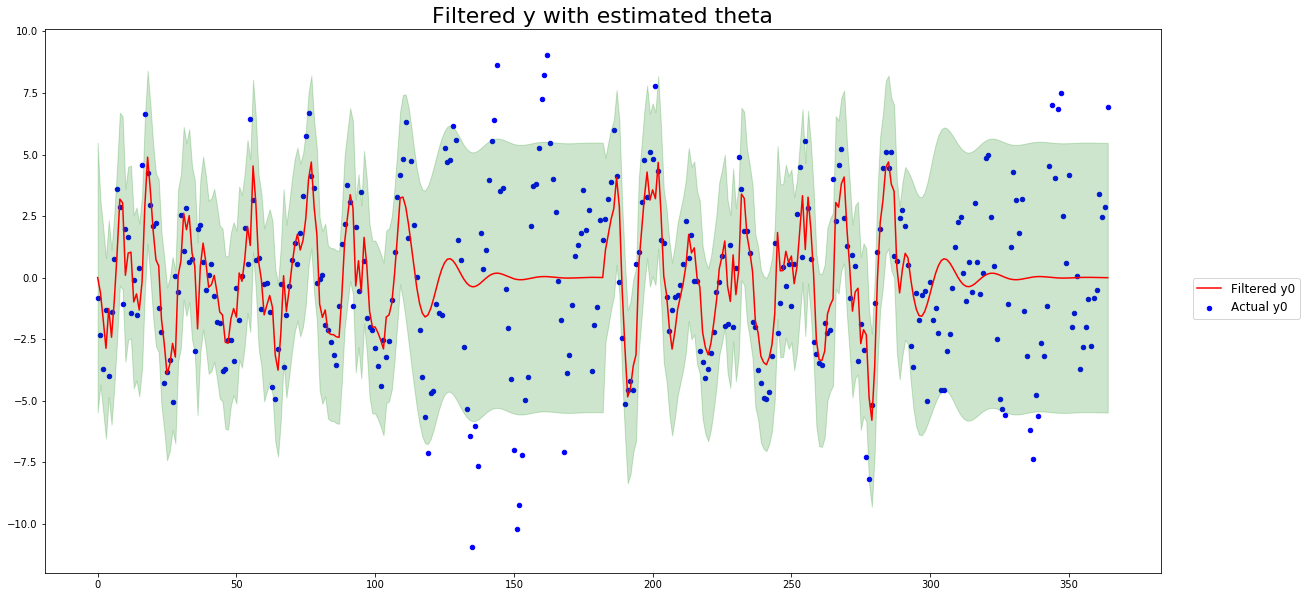

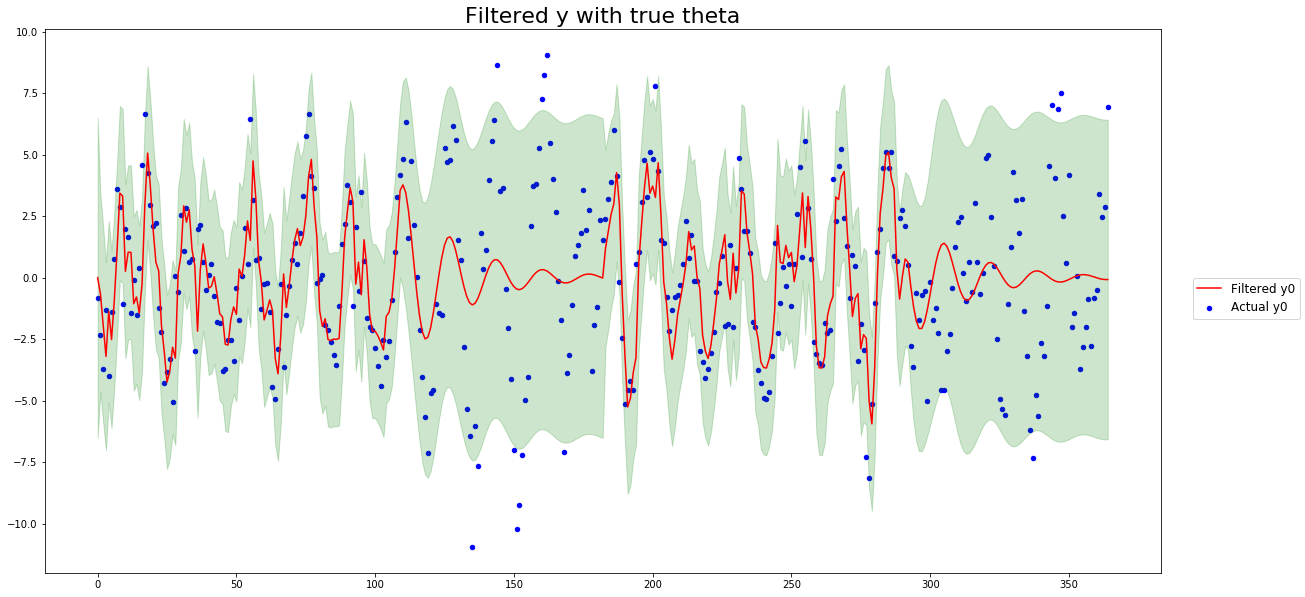

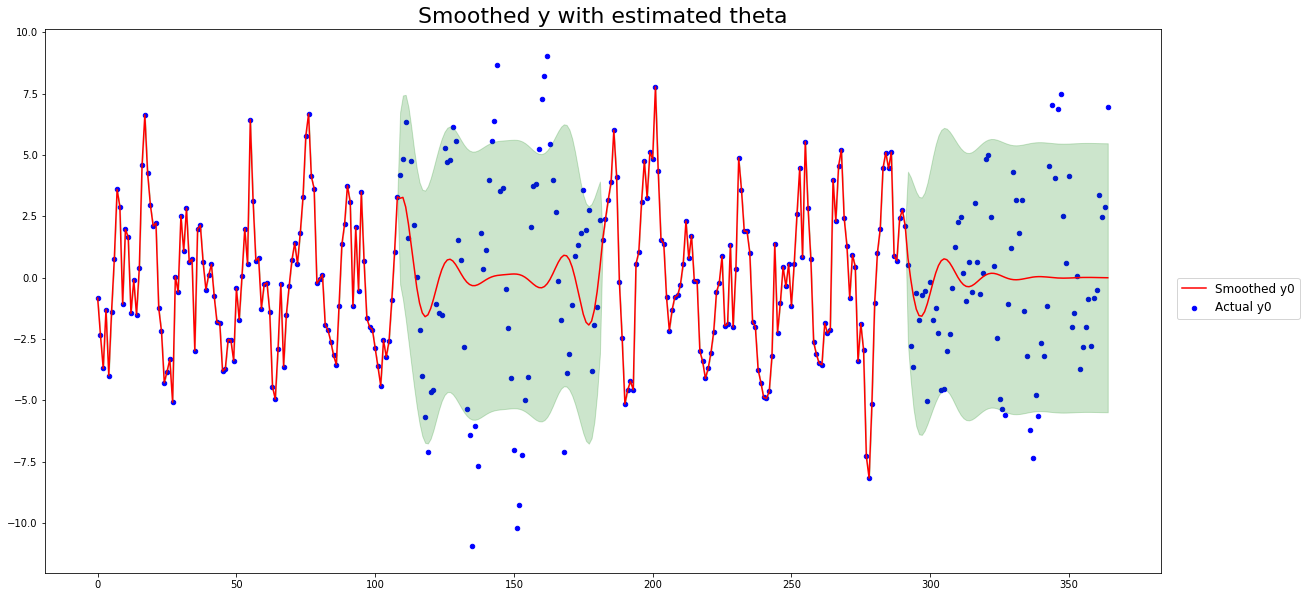

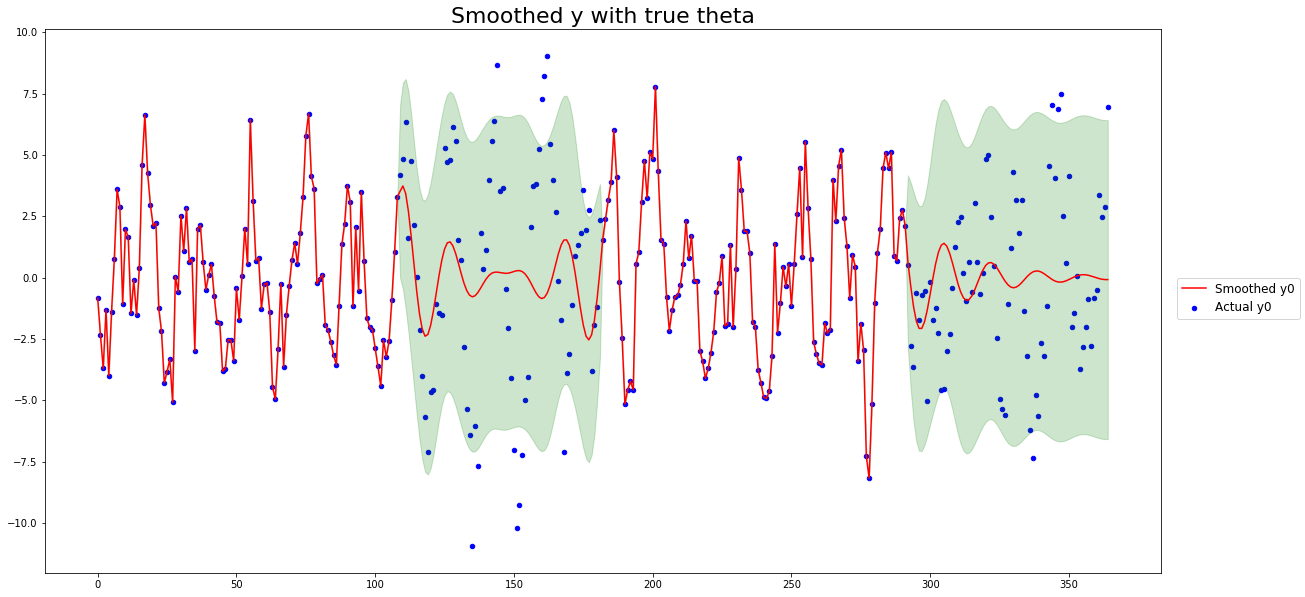

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 2.8507402860505646, 'mean_error': 0.01650689123052229}
Ture theta for training data: {'RMSE': 2.7175112530773453, 'mean_error': 0.021165863729209262}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 2.057520303812859, 'mean_error': -0.14515194577137305}
Ture theta for test data: {'RMSE': 2.0484199462773645, 'mean_error': -0.1480080930893887}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 3.429157435107682, 'mean_error': 0.19191118683558397}
Ture theta for forecast data: {'RMSE': 3.5408793396116005, 'mean_error': 0.17502874529836218}
